# Taller Simulación de ML

#Librerias y configuraciones previas


In [57]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import math

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
from sklearn.impute import MissingIndicator

from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.neighbors import LocalOutlierFactor

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
import os
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#Funciones

In [4]:
def plot_multiples_graficas(df, cols, num_cols, num_rows, tipo, targetVar, figsize=(16,8)):
    
    plt.rcParams['figure.figsize'] = figsize
    fig, axs = plt.subplots(num_rows, num_cols)
    
    for ind, col in enumerate(cols):
        i = math.floor(ind/num_cols)
        j = ind - i*num_cols
        
        if num_rows == 1:
            if num_cols == 1:
                if tipo == 'c': 
                    sns.countplot(x=df[col], ax=axs, dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs)
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs)
            else:
                if tipo == 'c':
                    sns.countplot(x=df[col], ax=axs[j], dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs[j])
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs[j])
        else:
            if num_cols == 1:
                if tipo == 'c':
                    sns.countplot(x=d[col], ax=axs[i], dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs[i])
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs[i])
            else:
                if tipo == 'c':
                    sns.countplot(x=df[col], ax=axs[i, j], dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs[i, j])
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs[i, j])

In [5]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [29]:
from scipy.stats import spearmanr
class Spearman_Correlation:
  def corr_spearman(self, Features):
        spearman = []
        valor_p = []
        Data_n = Features.values
        Data_n = np.asarray(Data_n)

        for _, n in enumerate(np.arange(0, Data_n.shape[1])):
            for _, m in enumerate(np.arange(0, Data_n.shape[1])):
                s_valor, p_valor = spearmanr(Data_n[:, n], Data_n[:, m])
                spearman.append(s_valor)
                valor_p.append(p_valor)

        spearman = np.asarray(spearman)
        spearman_r = spearman.reshape(Data_n.shape[1], Data_n.shape[1])
        valor_p = np.asarray(valor_p)
        p_value = valor_p.reshape(Data_n.shape[1], Data_n.shape[1])
        spearman_r, p_value = pd.DataFrame(
            spearman_r, index=Features.columns, columns=Features.columns
        ), pd.DataFrame(p_value, index=Features.columns, columns=Features.columns)
        return spearman_r, p_value

  def correlation_analysis(self, df_news_noscale):
        spearman_r, p_value_spearman = self.corr_spearman(df_news_noscale)
        columns = p_value_spearman.columns

        traverse = {}
        for row_index in range(p_value_spearman.shape[0]):
            traverse[row_index] = {}
            for column_index in range(p_value_spearman.shape[0]):
                traverse[row_index][column_index] = True

        for row_index in range(p_value_spearman.shape[0]):
            for column_index in range(p_value_spearman.shape[0]):
                if (
                    p_value_spearman[columns[column_index]][row_index] < 0.05
                    and row_index != column_index
                    and (
                        spearman_r[columns[column_index]][row_index] > 0.8
                        or spearman_r[columns[column_index]][row_index] < -0.8
                    )
                    and traverse[row_index][column_index] == True
                    and traverse[column_index][row_index] == True
                ):
                    print(
                        "({}, {}) (pvalue={:.3f}, corr={:.3f})".format(
                            columns[row_index],
                            columns[column_index],
                            p_value_spearman[columns[column_index]][row_index],
                            spearman_r[columns[column_index]][row_index],
                        )
                    )
                    traverse[row_index][column_index] = False

In [36]:
def build_model(X2,Y2):
    X2 = sm.add_constant(X2)
    lm = sm.OLS(Y2,X2).fit()
    print(lm.summary())
    return X2

In [55]:
def checkVIF(X2):
    vif = pd.DataFrame()
    vif['Features'] = X2.columns
    vif['VIF'] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

# 1 - Cancelación tarjetas de crédito - Regresión Logística

Este dataset contiene la información de 10.000 clientes de un banco, lo que se requiere es tener un modelo para predecir quien va a cancelar la tarjeta de crédito, lo que permita que se aborde al cliente proactivamente para conservarlo.

##Carga del dataset

Procedemos a realizar la carga del dataset directamente desde Kaggle:

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/' + input('Input the directory with your Kaggle json file: ')
!kaggle datasets download -d sakshigoyal7/credit-card-customers
!unzip \*.zip && rm *.zip

Input the directory with your Kaggle json file: Colab Notebooks
  0% 0.00/379k [00:00<?, ?B/s]
100% 379k/379k [00:00<00:00, 64.4MB/s]
Archive:  credit-card-customers.zip
  inflating: BankChurners.csv        


In [ ]:
data_bank=pd.read_csv('/content/BankChurners.csv')

In [ ]:
data_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

##Limpieza de datos y preparación

El dataset tiene dos columnas al final sobre clasificación de Bayes, por lo cual no las consideramos para el análisis. Así mismo, prescindimos de la característica Número de Cliente (CLIENTNUM), dado que es una identificación única y no aporta a nuestro experimento:

In [ ]:
data_bank.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1'], axis='columns', inplace=True)
data_bank.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis='columns', inplace=True)
data_bank.drop(['CLIENTNUM'], axis='columns', inplace=True)

In [ ]:
data_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

In [ ]:
data_bank.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


Procedemos a validar si existen registros duplicados:

In [ ]:
data_bank.loc[data_bank.duplicated()]

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio


Una vez eliminadas las características no relevantes, vamos a separar las categóricas y continuas para gestionarlas por separado:

In [ ]:
categorical_columns=data_bank.select_dtypes(include = ["object"]).columns.tolist()
continuous_columns=data_bank.select_dtypes(include = ["int64", "float64"]).columns.tolist()
categorical_data = data_bank[categorical_columns]
continuous_data = data_bank[continuous_columns]

Procedemos a validar los datos nulos, los cuales en este caso están como *Unknown* y los pasamos a *NAN* para poder tratarlos:

In [ ]:
for column in categorical_columns:
  values = list(data_bank[column].value_counts().index)
  print("Valores de la columna {columna} : {valores}".format(columna=column, valores=', '.join(values)))

Valores de la columna Attrition_Flag : Existing Customer, Attrited Customer
Valores de la columna Gender : F, M
Valores de la columna Education_Level : Graduate, High School, Unknown, Uneducated, College, Post-Graduate, Doctorate
Valores de la columna Marital_Status : Married, Single, Unknown, Divorced
Valores de la columna Income_Category : Less than $40K, $40K - $60K, $80K - $120K, $60K - $80K, Unknown, $120K +
Valores de la columna Card_Category : Blue, Silver, Gold, Platinum


In [ ]:
data_bank.replace('Unknown',np.nan, inplace=True)

In [ ]:
for col in data_bank.columns:
    print (col, np.sum(pd.isnull(data_bank[col])))

Attrition_Flag 0
Customer_Age 0
Gender 0
Dependent_count 0
Education_Level 1519
Marital_Status 749
Income_Category 1112
Card_Category 0
Months_on_book 0
Total_Relationship_Count 0
Months_Inactive_12_mon 0
Contacts_Count_12_mon 0
Credit_Limit 0
Total_Revolving_Bal 0
Avg_Open_To_Buy 0
Total_Amt_Chng_Q4_Q1 0
Total_Trans_Amt 0
Total_Trans_Ct 0
Total_Ct_Chng_Q4_Q1 0
Avg_Utilization_Ratio 0


Se visualizan que las características con datos nulos son: 

*   Education_Level con 1.519 registros
*   Income_Category con 1.112 registros
*   Marital_Status con 749 registros



 

Ahora, antes de aplicar la imputación de los datos nulos, vamos a convertir los datos categóricos a numéricos a través de la creación de variables dummy y en el caso de la variable de salida, asignando 1 a los clientes existentes y 0 a los que ya no son clientes:

In [ ]:
data_bank["Attrition_Flag"].replace('Existing Customer', "Act",inplace=True)
data_bank["Attrition_Flag"].replace('Attrited Customer', "Canc",inplace=True)

In [ ]:
cat_columns = ['Gender','Education_Level','Marital_Status','Income_Category','Card_Category']
cat_data_sin_y = data_bank[cat_columns]

In [ ]:
data_dummy_encoding = pd.get_dummies(cat_data_sin_y, drop_first = True)
print(data_dummy_encoding.info())
data_dummy_encoding.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   Gender_M                        10127 non-null  uint8
 1   Education_Level_Doctorate       10127 non-null  uint8
 2   Education_Level_Graduate        10127 non-null  uint8
 3   Education_Level_High School     10127 non-null  uint8
 4   Education_Level_Post-Graduate   10127 non-null  uint8
 5   Education_Level_Uneducated      10127 non-null  uint8
 6   Marital_Status_Married          10127 non-null  uint8
 7   Marital_Status_Single           10127 non-null  uint8
 8   Income_Category_$40K - $60K     10127 non-null  uint8
 9   Income_Category_$60K - $80K     10127 non-null  uint8
 10  Income_Category_$80K - $120K    10127 non-null  uint8
 11  Income_Category_Less than $40K  10127 non-null  uint8
 12  Card_Category_Gold              10127 non-null  uint8
 13  C

,Gender_M,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Marital_Status_Married,Marital_Status_Single,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
2,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0


Realizamos la imputación por el método de la media:

In [ ]:
imp = SimpleImputer(missing_values = np.nan, strategy= 'mean')
imp.fit(data_dummy_encoding)
data_bank_imp_media = imp.transform(data_dummy_encoding)
nombres = data_dummy_encoding.columns
data_bank_imp_media = pd.DataFrame(data_bank_imp_media, columns = nombres)
display(data_bank_imp_media)

,Gender_M,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Marital_Status_Married,Marital_Status_Single,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10123,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10124,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10125,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Revalidamos si luego de la imputación nos quedaron datos nulos o no:

In [ ]:
Indicador = MissingIndicator(missing_values = np.nan)
Indicador.fit(data_bank_imp_media)
Datos_Indicador = Indicador.transform(data_bank_imp_media)
display(Datos_Indicador)
print("Características donde hay datos faltantes: ", Indicador.features_)

array([], shape=(10127, 0), dtype=bool)

Características donde hay datos faltantes:  []


Procedemos a unir los datos categóricos y los datos continuos:

In [ ]:
data_bank_processed = pd.concat([data_bank_imp_media, continuous_data], axis = 1)
data_bank_processed = data_bank_processed.astype(float)
y = data_bank["Attrition_Flag"]

In [ ]:
data_bank_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender_M                        10127 non-null  float64
 1   Education_Level_Doctorate       10127 non-null  float64
 2   Education_Level_Graduate        10127 non-null  float64
 3   Education_Level_High School     10127 non-null  float64
 4   Education_Level_Post-Graduate   10127 non-null  float64
 5   Education_Level_Uneducated      10127 non-null  float64
 6   Marital_Status_Married          10127 non-null  float64
 7   Marital_Status_Single           10127 non-null  float64
 8   Income_Category_$40K - $60K     10127 non-null  float64
 9   Income_Category_$60K - $80K     10127 non-null  float64
 10  Income_Category_$80K - $120K    10127 non-null  float64
 11  Income_Category_Less than $40K  10127 non-null  float64
 12  Card_Category_Gold              

##Visualización de datos

In [ ]:
data_bank.groupby('Attrition_Flag').Attrition_Flag.count().sort_values(ascending=False)

Attrition_Flag
Act     8500
Canc    1627
Name: Attrition_Flag, dtype: int64

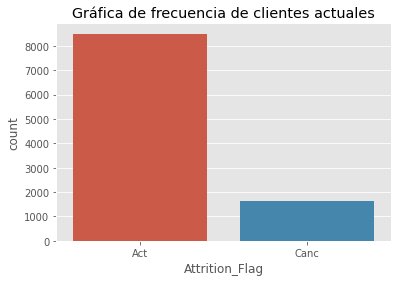

In [ ]:
plt.figure(figsize=(6,4))

plt.title('Gráfica de frecuencia de clientes actuales')
sns.countplot(x=data_bank['Attrition_Flag'])

plt.show()

En la gráfica anterior, se visualiza que los datos se encuentran desproporcionadamente desbalanceados. Primero realizaremos el modelo sin balancear estos datos y posterior los balancearemos para comparar que nos arroja.

Vamos a validar como se comportan nuestras demás variables categóricas:

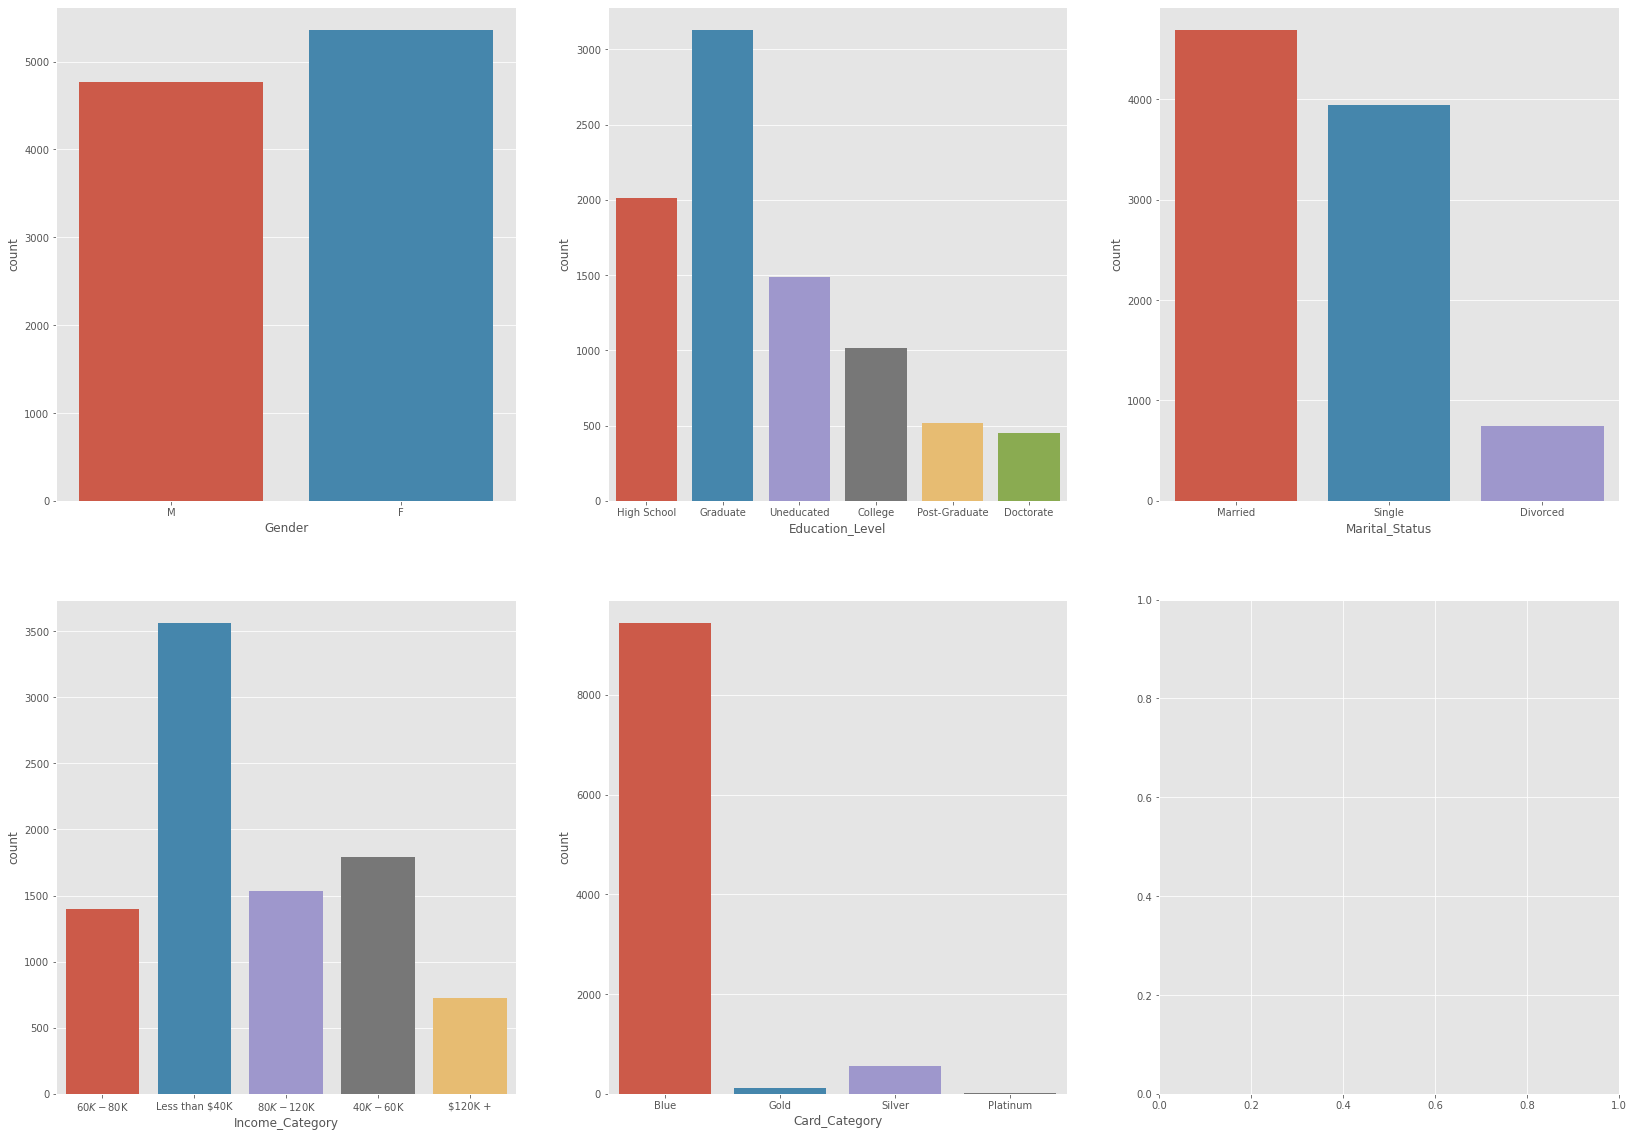

In [ ]:
plot_multiples_graficas(cat_data_sin_y,cat_columns, 3, 2, 'c', None, (28,20))

Encontramos que la característica *Gender* tiene una buena proporción de los datos entre ambos géneros. Para el caso de *Education_Level*, tenemos mayor cantidad en *Graduate* seguido por *High Schoo*l. En *Marital_Status* se tienen pocos registros con el estado *Divorced*. La característica *Income_Category*, la cual representa el ingreso anual del titular de la cuenta, tiene la mayor cantidad de datos en la categoría *Less than $40K*. Y por último para *Card_Category*, vemos que casi todos los clientes tienen la tarjeta *Blue*.

##Análisis con datos desbalanceados

###Dividir el conjunto de datos

En este caso, el 70% de los datos se utilizarán para entrenar el modelo. Procedemos a crear los datos de entrenamiento y de prueba:


In [ ]:
vDep = list(data_bank_processed.columns)

X = data_bank_processed[vDep]
y = data_bank["Attrition_Flag"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1), 
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [ ]:
X[continuous_columns].head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,45.0,3.0,39.0,5.0,1.0,3.0,12691.0,777.0,11914.0,1.335,1144.0,42.0,1.625,0.061
1,49.0,5.0,44.0,6.0,1.0,2.0,8256.0,864.0,7392.0,1.541,1291.0,33.0,3.714,0.105
2,51.0,3.0,36.0,4.0,1.0,0.0,3418.0,0.0,3418.0,2.594,1887.0,20.0,2.333,0.000
3,40.0,4.0,34.0,3.0,4.0,1.0,3313.0,2517.0,796.0,1.405,1171.0,20.0,2.333,0.760
4,40.0,3.0,21.0,5.0,1.0,0.0,4716.0,0.0,4716.0,2.175,816.0,28.0,2.500,0.000


Procedemos a escalar las variables continuas, dado que se evidencian diferencias considerables en los rangos de valores que registran en cada una de ellas.

In [ ]:
scaler = MinMaxScaler()
num_vars = continuous_columns
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.fit_transform(X_test[num_vars])

X_train[num_vars].head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
8606,0.468085,0.6,0.534884,0.2,0.333333,0.166667,0.031795,0.628526,0.026222,0.223727,0.398267,0.589147,0.178000,0.635636
4209,0.659574,0.4,0.720930,0.8,0.166667,0.333333,0.126179,0.748510,0.107930,0.226671,0.231414,0.565891,0.253143,0.336336
6776,0.553191,0.6,0.767442,1.0,0.833333,0.500000,0.041590,0.858959,0.018805,0.173094,0.205534,0.604651,0.238000,0.768769
6042,0.574468,0.2,0.744186,1.0,0.333333,0.500000,0.258866,0.000000,0.289688,0.198999,0.199721,0.496124,0.184000,0.000000
4638,0.638298,0.4,0.813953,0.6,0.500000,0.500000,0.091956,0.979340,0.058297,0.227259,0.152990,0.496124,0.194857,0.550551


###Creación del modelo

Para la creación de este modelo, vamos a tomar los parámetros:

*   *ovr − (one-versus-rest)*, dado que tenemos una clasificación binaria.

*   *liblinear*, puesto que nuestro datasets es pequeño.

*   *lbfgs (default)*, para validar otra opción de parámetro.

In [ ]:
modelLRovrLinea = LogisticRegression(multi_class = "ovr", solver='liblinear',  random_state=0)
modelLRovrlbfgs = LogisticRegression(multi_class = "ovr", solver='lbfgs',  random_state=0) 

modelLRovrLinea.fit(X_train, y_train)
modelLRovrlbfgs.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', random_state=0)

###Evaluación del modelo



####Accuracy

In [ ]:
y_predovrLinea = modelLRovrLinea.predict(X_test)
y_predovrlbfgs = modelLRovrlbfgs.predict(X_test)

print("===========Accuracy Logistic Regression ================")
print("ovr - Linear       :",metrics.accuracy_score(y_test, y_predovrLinea))
print("ovr - lbfgs        :",metrics.accuracy_score(y_test, y_predovrlbfgs))

===========Accuracy Logistic Regression ================
ovr - Linear       : 0.907864429088516
ovr - lbfgs        : 0.9081934846989141


Al evaluar los modelos con los parámetros se evidencia que la precisión es de 0.91 en ambos casos.

####Matriz de confusión

In [ ]:
y = data_bank["Attrition_Flag"]

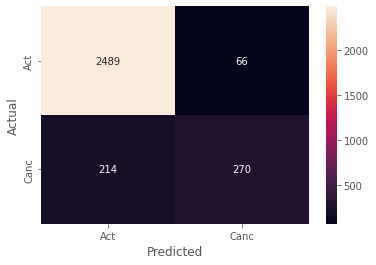

              precision    recall  f1-score   support

         Act       0.92      0.97      0.95      2555
        Canc       0.80      0.56      0.66       484

    accuracy                           0.91      3039
   macro avg       0.86      0.77      0.80      3039
weighted avg       0.90      0.91      0.90      3039



In [ ]:
conf_mat = confusion_matrix(y_test, y_predovrLinea)

fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat
            , annot=True
            , fmt='d'
            , xticklabels=data_bank["Attrition_Flag"].sort_values().unique()
            , yticklabels=data_bank["Attrition_Flag"].sort_values().unique()
           )
plt.ylabel('Real')
plt.xlabel('Predicted')
plt.show()

print(metrics.classification_report(y_test, y_predovrLinea, target_names=data_bank["Attrition_Flag"].sort_values().unique()))

En la matriz de confusión de los datos no balanceados, tal como se esperaba, se visualiza un muy buen comportamiento para las predicciones de los clientes activos con una sensibilidad del 97%, pero en el caso de los clientes cancelados, podemos ver que la especificidad es del 56%. 
En este modelo tenemos precisiones de 92% para los activos y 80% para los cancelados.
Basados en estas métricas, podemos ver que el modelo es muy bueno para predecir los clientes activos, pero no tanto los que van a cancelar.

####ROC

In [ ]:
e_dataframe = pd.DataFrame(y_test)
e_dataframe.replace('Act',1, inplace=True)
e_dataframe.replace('Canc', 0,inplace=True)
arr = e_dataframe.to_numpy()

AUC: 0.92


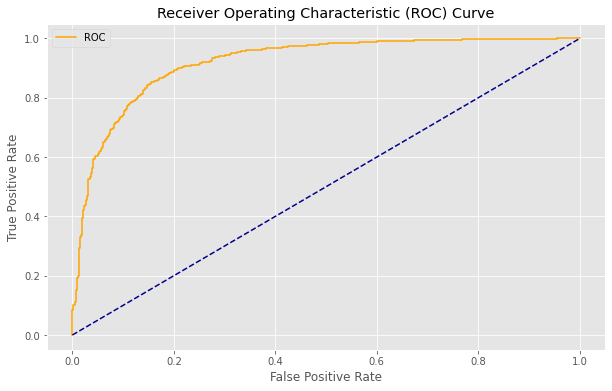

In [ ]:
fig = plt.figure(figsize=(10,6))

probs = modelLRovrLinea.predict_proba(X_test)
probs = probs[:, 1]
auc = roc_auc_score(arr, probs*(-1))

print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(arr, probs*(-1))
plot_roc_curve(fpr, tpr)

##Análisis con datos balanceados

###Dividir el conjunto de datos

In [ ]:
vDep = list(data_bank_processed.columns)

Xb = data_bank_processed[vDep]
yb = data_bank["Attrition_Flag"]

In [ ]:
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
                                        Xb,
                                        yb.values.reshape(-1,1), 
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [ ]:
scaler = MinMaxScaler()
num_vars = continuous_columns
Xb_train[num_vars] = scaler.fit_transform(Xb_train[num_vars])
Xb_test[num_vars] = scaler.fit_transform(Xb_test[num_vars])

###Creación del modelo

Ahora procedemos a realizar el análisis con los datos balanceados:

In [ ]:
modelLRovrLinea_b = LogisticRegression(multi_class = "ovr", solver='liblinear', class_weight= "balanced", random_state=0)
modelLRovrlbfgs_b = LogisticRegression(multi_class = "ovr", solver='lbfgs', class_weight= "balanced",  random_state=0) 

modelLRovrLinea_b.fit(Xb_train, yb_train)
modelLRovrlbfgs_b.fit(Xb_train, yb_train)

LogisticRegression(class_weight='balanced', multi_class='ovr', random_state=0)

###Evaluación del modelo

####Accuracy

In [ ]:
y_predovrLinea_b = modelLRovrLinea_b.predict(Xb_test)
y_predovrlbfgs_b = modelLRovrlbfgs_b.predict(Xb_test)
print("===========Accuracy Logistic Regression ================")
print("ovr - Linear       :",metrics.accuracy_score(yb_test, y_predovrLinea_b))
print("ovr - lbfgs        :",metrics.accuracy_score(yb_test, y_predovrlbfgs_b))

===========Accuracy Logistic Regression ================
ovr - Linear       : 0.8512668641000329
ovr - lbfgs        : 0.8496215860480422


Se puede observar que con los datos balanceados perdemos precisión en el modelo, comparado con los datos no balanceados, esta se disminuye hasta el 0.8 

####Matriz de confusión

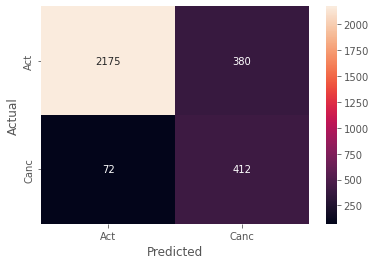

              precision    recall  f1-score   support

         Act       0.97      0.85      0.91      2555
        Canc       0.52      0.85      0.65       484

    accuracy                           0.85      3039
   macro avg       0.74      0.85      0.78      3039
weighted avg       0.90      0.85      0.86      3039



In [ ]:
conf_matb = confusion_matrix(yb_test, y_predovrLinea_b)

fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_matb
            , annot=True
            , fmt='d'
            , xticklabels=data_bank["Attrition_Flag"].sort_values().unique()
            , yticklabels=data_bank["Attrition_Flag"].sort_values().unique()
           )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(metrics.classification_report(yb_test, y_predovrLinea_b, target_names=data_bank["Attrition_Flag"].sort_values().unique()))

Con los datos balanceados, vemos que la sensibilidad en los clientes activos pasa al 85%, pero en el caso de los clientes cancelados, podemos ver que la especificidad mejora al 85%, lo que nos permite detectar más clientes que van a cancelar. En este modelo tenemos precisiones de 97% para los activos y 52% para los cancelados. Basados en estas métricas, aunque la precisión en el caso de los cancelados baja, nos permite tener una predicción mayor de los clientes que van a cancelar para poder intervenirlos de manera proactiva, lo cual es el objetivo buscado por el negocio.

####ROC

AUC: 0.92


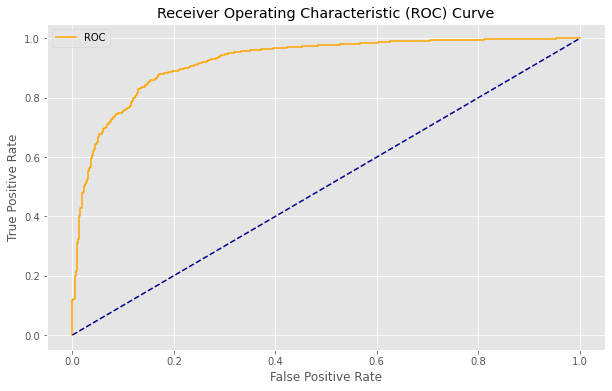

In [ ]:
fig = plt.figure(figsize=(10,6))

probs = modelLRovrLinea_b.predict_proba(Xb_test)
probs = probs[:, 1]
auc = roc_auc_score(arr, probs*(-1))

print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(arr, probs*(-1))
plot_roc_curve(fpr, tpr)

Se evidencia que el ROC es del 0.92, lo que nos indica que el test del modelo es bueno.

*************DEBEMOS REVISAR ESTOS ERRORES, ME SALE ERROR:

In [ ]:
# Error de test del modelo 
X = sm.add_constant(X) #Adding the constant
lm = sm.OLS(yb_train,Xb_train).fit() # fitting the model

predicciones = lm.predict(exog = Xb_test)

mse = mean_squared_error (y_true  = yb_test, y_pred  = predicciones, squared = True)
rmse = mean_squared_error (y_true  = yb_test, y_pred  = predicciones, squared = False)
MAE = mean_absolute_error (y_true  = yb_test, y_pred  = predicciones)
MedAE = median_absolute_error (y_true  = yb_test, y_pred  = predicciones)
r2 = r2_score (y_true  = yb_test, y_pred  = predicciones)

print(f"El error MSE   de test es: {mse}")
print(f"El error RMSE  de test es: {rmse}")
print(f"El error MAE   de test es: {MAE}")
print(f"El error MedAE de test es: {MedAE}")
print(f"El error R2    de test es: {r2}")

# 2 - Costo manejo desperdicios - Regresión Lineal

Este dataset contiene cerca de 4.300 registros con la información de los residuos municipales recogidos y tratados, la idea es que con esta información podamos predecir el costo de la Gestión de Residuos Municipales.

##Carga del dataset

Procedemos a realizar la carga del dataset directamente desde Kaggle:

In [6]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/' + input('Input the directory with your Kaggle json file: ')
!kaggle datasets download -d shashwatwork/municipal-waste-management-cost-prediction
!unzip \*.zip && rm *.zip

Input the directory with your Kaggle json file: Colab Notebooks
  0% 0.00/792k [00:00<?, ?B/s]
100% 792k/792k [00:00<00:00, 100MB/s]
Archive:  municipal-waste-management-cost-prediction.zip
  inflating: public_data_waste_fee.csv  


In [7]:
df = pd.read_csv('public_data_waste_fee.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4341 entries, 0 to 4340
Data columns (total 39 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   region      4341 non-null   object 
 1   province    4341 non-null   object 
 2   name        4335 non-null   object 
 3   tc          4341 non-null   float64
 4   cres        4289 non-null   float64
 5   csor        4274 non-null   float64
 6   istat       4341 non-null   int64  
 7   area        4335 non-null   float64
 8   pop         4341 non-null   int64  
 9   alt         4335 non-null   float64
 10  isle        4335 non-null   float64
 11  sea         4335 non-null   float64
 12  pden        4335 non-null   float64
 13  wden        4335 non-null   float64
 14  urb         4335 non-null   float64
 15  fee         4341 non-null   object 
 16  d_fee       4341 non-null   int64  
 17  sample      4341 non-null   int64  
 18  organic     3829 non-null   float64
 19  paper       4316 non-null  

##Limpieza de datos y preparación

Se procede a eliminar las características que no aportan al modelo: *region, province, name, istat y gdp*, esta última dado que al validar la información que contiene, se evidencia que es igual a *finance*.

In [8]:
df.drop(['region'], axis='columns', inplace=True)
df.drop(['province'], axis='columns', inplace=True)
df.drop(['name'], axis='columns', inplace=True)
df.drop(['istat'], axis='columns', inplace=True)
df.drop(['gdp'], axis='columns', inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4341 entries, 0 to 4340
Data columns (total 34 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tc          4341 non-null   float64
 1   cres        4289 non-null   float64
 2   csor        4274 non-null   float64
 3   area        4335 non-null   float64
 4   pop         4341 non-null   int64  
 5   alt         4335 non-null   float64
 6   isle        4335 non-null   float64
 7   sea         4335 non-null   float64
 8   pden        4335 non-null   float64
 9   wden        4335 non-null   float64
 10  urb         4335 non-null   float64
 11  fee         4341 non-null   object 
 12  d_fee       4341 non-null   int64  
 13  sample      4341 non-null   int64  
 14  organic     3829 non-null   float64
 15  paper       4316 non-null   float64
 16  glass       4308 non-null   float64
 17  wood        3246 non-null   float64
 18  metal       4095 non-null   float64
 19  plastic     4302 non-null  

In [10]:
categorical_col=df.select_dtypes(include = ["object"]).columns.tolist()
continuous_col=df.select_dtypes(include = ["int64", "float64"]).columns.tolist()
categorical_df = df[categorical_col]
continuous_df = df[continuous_col]

Podemos observar que solo nos quedó como variable categórica: *fee*. Ahora, antes de aplicar la imputación de los datos nulos, vamos a convertir esta variable a numérica a través de la creación de variables dummy:     

In [11]:
df_dummy_encoding = pd.get_dummies(categorical_df, drop_first = True)
print(df_dummy_encoding.info())
df_dummy_encoding.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4341 entries, 0 to 4340
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   fee_STANDARD  4341 non-null   uint8
dtypes: uint8(1)
memory usage: 4.4 KB
None


,fee_STANDARD
0,0
1,0
2,0
3,0
4,1


Procedemos a validar si existen registros duplicados:

In [12]:
df.loc[df.duplicated()]

,tc,cres,csor,area,pop,alt,isle,sea,pden,wden,...,msw_un,msw,sor,geo,roads,s_wteregio,s_landfill,proads,wage,finance


Ahora revisemos los datos faltantes:


    Cantidad de datos faltantes por columna 


    


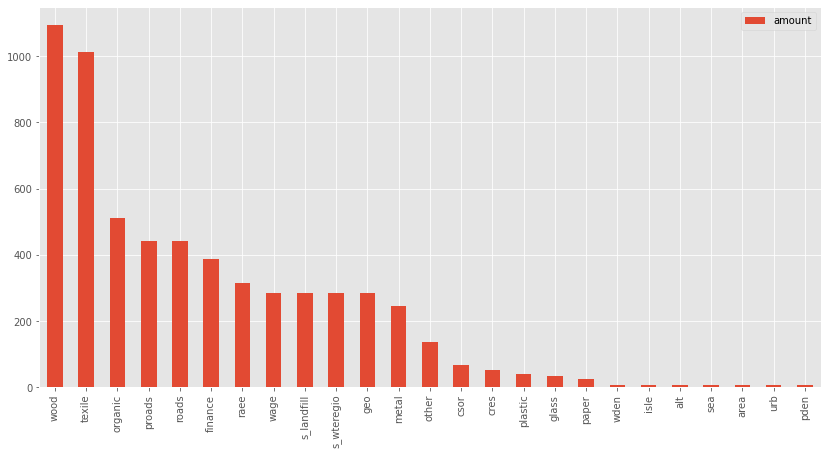

In [13]:
def print_null_data(df):
  serie = df.isna().sum()
  df1 = pd.DataFrame(serie, columns=["amount"])
  df2 = df1[df1["amount"] > 0].sort_values("amount", ascending=False)
  return df2

break_lines = 2 * "\n"
print(
    '''
    Cantidad de datos faltantes por columna {}
    '''.format(break_lines)
)
print_null_data(df).plot.bar(figsize=(14, 7))

La variable que mayor datos faltantes presenta es *wood*, seguido de *textile*.

In [14]:
def print_total_nan(df):
  df1 = print_null_data(df)
  return pd.DataFrame(df1.sum(), columns=["amount"])

print(
    '''
    Cantidad de datos faltantes en la base de datos {}
    '''.format(break_lines)
)
print_total_nan(df)


    Cantidad de datos faltantes en la base de datos 


    


,amount
amount,5986


El paso a seguir es juntar la variable categórica con las demás variables para realizar la imputación por el método de la media:

In [15]:
df_residuos = pd.concat([continuous_df, df_dummy_encoding], axis = 1) 

In [16]:
imp1 = SimpleImputer(missing_values = np.nan, strategy= 'mean')
imp1.fit(df_residuos)
df_imp_media = imp1.transform(df_residuos)
nombres1 = df_residuos.columns
df_imp_media = pd.DataFrame(df_imp_media, columns = nombres1)
display(df_imp_media)

,tc,cres,csor,area,pop,alt,isle,sea,pden,wden,...,msw,sor,geo,roads,s_wteregio,s_landfill,proads,wage,finance,fee_STANDARD
0,502.250000,129.270004,66.419998,283.750000,22648.0,1.000000,0.000000,1.000000,79.816742,119671.476562,...,33956781.0,60.07,3.000000,285.000000,33.105049,15.233530,4.354818,9.438692,7.488041,0.0
1,228.050003,49.520000,44.139999,34.439999,4952.0,1.000000,0.000000,1.000000,143.786301,70030.984375,...,2411867.0,75.93,3.000000,11.000000,33.105049,15.233530,6.082588,9.510139,7.323284,0.0
2,268.010010,50.610001,44.599998,26.620001,3895.0,1.000000,0.000000,1.000000,146.318558,81116.523438,...,2159322.0,78.49,3.000000,49.000000,33.105049,15.233530,4.335555,8.891356,7.485891,0.0
3,199.089996,41.110001,40.439999,84.300003,7140.0,1.000000,0.000000,1.000000,84.697502,43320.460938,...,3651915.0,78.89,3.000000,165.000000,33.105049,15.233530,3.710479,9.433685,7.298514,0.0
4,233.639999,58.270000,25.950001,35.700001,12193.0,1.000000,0.000000,1.000000,341.540619,201565.265625,...,7195880.0,42.06,1.000000,60.000000,4.046452,45.411903,5.274037,9.125561,7.464867,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4336,122.500000,44.320000,43.590000,40.995045,5031.0,310.052134,0.005075,0.168397,405.048252,192057.791485,...,2113374.0,71.70,2.290804,101.931121,21.867460,20.000860,4.253962,9.446968,7.448094,1.0
4337,126.220001,51.250000,22.620001,40.995045,2623.0,310.052134,0.005075,0.168397,405.048252,192057.791485,...,1240725.0,79.55,2.290804,101.931121,21.867460,20.000860,4.253962,9.446968,7.448094,1.0
4338,94.190002,17.080000,47.700001,40.995045,13515.0,310.052134,0.005075,0.168397,405.048252,192057.791485,...,5554469.0,88.30,2.290804,101.931121,21.867460,20.000860,4.253962,9.446968,7.448094,1.0
4339,169.559998,70.230003,75.250000,40.995045,4683.0,310.052134,0.005075,0.168397,405.048252,192057.791485,...,2172620.0,67.73,2.290804,101.931121,21.867460,20.000860,4.253962,9.446968,7.448094,1.0


### Extrayendo datos atípicos

Vamos a normalizar los datos y a generar el diagrama de cajas para visualizar el comportamiento de los datos atípicos:

*****DEBEMOS HACER EL PROCESO DE DATOS ATIPICOS CON LA VARIABLE DE SALIDA???? 

In [18]:
MinMax = MinMaxScaler(copy=True, feature_range=(0, 1))
nombres = df_imp_media.columns
Datos_Min_Max = MinMax.fit_transform(df_imp_media)
Datos_Min_Max = pd.DataFrame(Datos_Min_Max, columns = nombres)

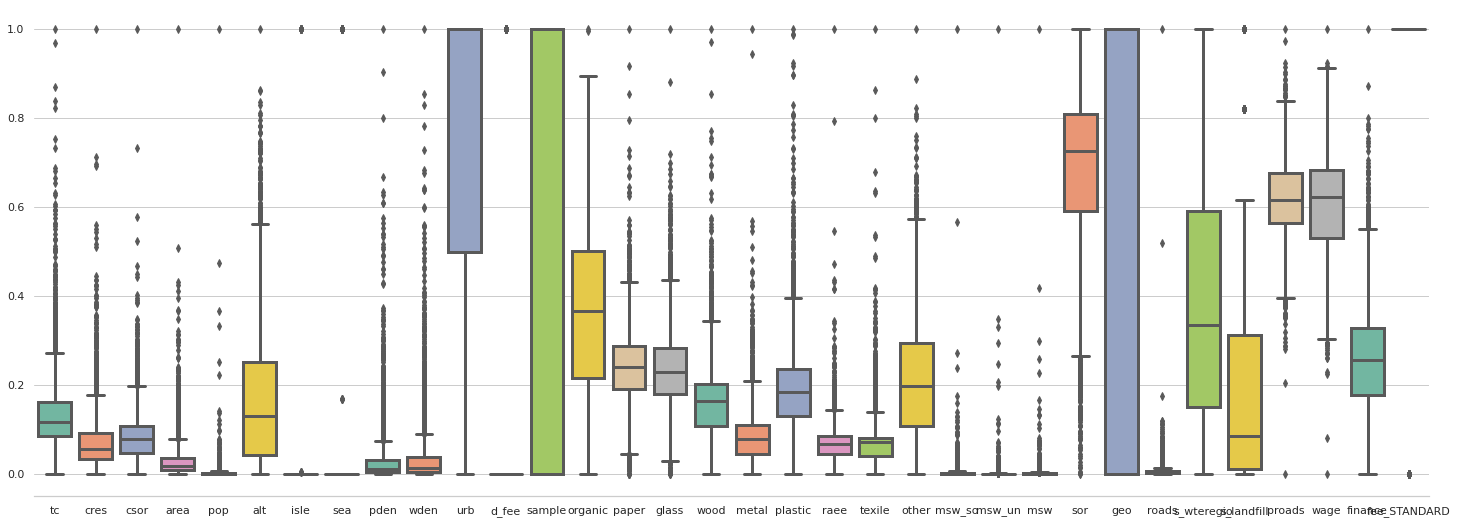

In [19]:
sns.set(rc={'figure.figsize':(25,9)})
sns.set(style="whitegrid")
sns.boxplot(data = Datos_Min_Max, linewidth = 3, palette="Set2", fliersize = 5)
sns.despine(left=True)

Se visualiza una alta presencia de datos atípicos, por lo cual procederemos a tratarlos con el método LOF:

In [27]:
LOF = LocalOutlierFactor(n_neighbors = 5, algorithm = 'auto', contamination = 'auto', metric = 'euclidean')
Filtrado = LOF.fit_predict(Datos_Min_Max)

NOF = LOF.negative_outlier_factor_ 
radio_outiler = (NOF.max() - NOF)/(NOF.max() - NOF.min())
ground_truth = np.ones(len(Datos_Min_Max), dtype = int) 
n_errors = (Filtrado != ground_truth).sum()

In [28]:
print("Detección: ", Filtrado)
print("Factores atípicos negativos: ", NOF)
print("Número de muestras o filas con datos atípicos: ", n_errors)

Detección:  [-1  1  1 ... -1  1  1]
Factores atípicos negativos:  [-1.50210638 -1.03573607 -1.09144462 ... -1.50458938 -1.07807285
 -1.0717653 ]
Número de muestras o filas con datos atípicos:  184


Ahora, vamos a eliminar las muestras o filas de la base de datos donde el algoritmo LOF identificó como datos atípicos:

In [23]:
pos = np.where(Filtrado == ground_truth)
pos = np.asarray(pos)
pos = np.hstack(pos)
datos_sin_outilers_LOF = Datos_Min_Max.loc[pos, :]
print("Número de muestras sin outilers:", datos_sin_outilers_LOF.shape[0])
display(datos_sin_outilers_LOF)

Número de muestras sin outilers: 4157


,tc,cres,csor,area,pop,alt,isle,sea,pden,wden,...,msw,sor,geo,roads,s_wteregio,s_landfill,proads,wage,finance,fee_STANDARD
1,0.212623,0.067938,0.070408,0.026661,0.001879,0.000000,0.000000,1.000000,0.011659,0.013890,...,0.001414,0.778361,1.000000,0.000668,0.508354,0.130787,0.765325,0.627870,0.238620,0.0
2,0.254610,0.069574,0.071203,0.020586,0.001475,0.000000,0.000000,1.000000,0.011868,0.016117,...,0.001264,0.804690,1.000000,0.003207,0.508354,0.130787,0.623826,0.391628,0.273677,0.0
3,0.182195,0.055311,0.064015,0.065394,0.002715,0.000000,0.000000,1.000000,0.006783,0.008524,...,0.002147,0.808804,1.000000,0.010956,0.508354,0.130787,0.573199,0.598681,0.233280,0.0
4,0.218497,0.081075,0.038979,0.027640,0.004646,0.000000,0.000000,1.000000,0.027975,0.040315,...,0.004241,0.430011,0.000000,0.003941,0.062136,0.470140,0.699838,0.481044,0.269144,1.0
5,0.217310,0.059890,0.080619,0.084069,0.001134,0.000000,0.000000,0.000000,0.002082,0.002941,...,0.000983,0.812198,1.000000,0.004276,0.508354,0.130787,0.578544,0.624850,0.388021,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4335,0.099408,0.033391,0.118700,0.031753,0.002186,0.170277,0.005075,0.168397,0.033214,0.038405,...,0.001437,0.714389,0.645402,0.006743,0.335792,0.184396,0.617218,0.603752,0.265528,1.0
4336,0.101720,0.060131,0.069458,0.031753,0.001909,0.170277,0.005075,0.168397,0.033214,0.038405,...,0.001237,0.734855,0.645402,0.006743,0.335792,0.184396,0.617218,0.603752,0.265528,1.0
4337,0.105629,0.070535,0.033226,0.031753,0.000989,0.170277,0.005075,0.168397,0.033214,0.038405,...,0.000722,0.815592,0.645402,0.006743,0.335792,0.184396,0.617218,0.603752,0.265528,1.0
4339,0.151167,0.099032,0.124160,0.031753,0.001776,0.170277,0.005075,0.168397,0.033214,0.038405,...,0.001272,0.694024,0.645402,0.006743,0.335792,0.184396,0.617218,0.603752,0.265528,1.0


In [24]:
print(Datos_Min_Max.shape)
print(datos_sin_outilers_LOF.shape)

(4341, 34)
(4157, 34)


### Validando correlaciones

Validemos la correlación entre variables para determinar si debemos descartar alguna:

In [30]:
Spearman_Correlation().correlation_analysis(datos_sin_outilers_LOF)

(pop, msw_so) (pvalue=0.000, corr=0.953)
(pop, msw_un) (pvalue=0.000, corr=0.888)
(pop, msw) (pvalue=0.000, corr=0.972)
(pden, wden) (pvalue=0.000, corr=0.976)
(d_fee, fee_STANDARD) (pvalue=0.000, corr=-1.000)
(msw_so, msw_un) (pvalue=0.000, corr=0.823)
(msw_so, msw) (pvalue=0.000, corr=0.975)
(msw_un, msw) (pvalue=0.000, corr=0.919)


Validando a través del método de Spearman, las correlaciones más relevantes y sus correspondientes valores P, se decide filtrar las siguientes características:

1.   msw_so: debido a que se puede ver representada por msw
2.   msw_un: debido a que se puede ver representada por msw
3.   fee_STANDARD: debido a que se ve representada por d_fee

Las demás características aunque nos muestran correlaciones altas, se puede considerar que tienen información relevante para el modelo, por lo cual no es lo adecuado filtrarlas.

In [32]:
datos_sin_outilers_LOF.drop(["msw_so"], axis='columns', inplace=True)
datos_sin_outilers_LOF.drop(["msw_un"], axis='columns', inplace=True)
datos_sin_outilers_LOF.drop(["fee_STANDARD"], axis='columns', inplace=True)

## Dividir el conjunto de datos

En este caso, el 70% de los datos se utilizarán para entrenar el modelo. Procedemos a crear los datos de entrenamiento y de prueba:


In [46]:
vDep2 = list(datos_sin_outilers_LOF.columns)
vDep2.remove('finance')

In [47]:
X2 = datos_sin_outilers_LOF[vDep2]
Y2 = datos_sin_outilers_LOF['finance']

In [48]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(
                                        X2,
                                        Y2.values.reshape(-1,1), 
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

##Creación del modelo

In [49]:
X2_train = build_model(X2_train,Y2_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     103.7
Date:                Thu, 17 Nov 2022   Prob (F-statistic):               0.00
Time:                        14:56:36   Log-Likelihood:                 3247.5
No. Observations:                2909   AIC:                            -6433.
Df Residuals:                    2878   BIC:                            -6248.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3955      0.025     15.940      0.0

### Afinación del modelo

Podemos visualizar a través del R2 que el modelo no tiene un buen ajuste, por lo cual procedemos a realizar una afinación por el método RFE.

In [64]:
lm = LinearRegression(normalize=True)
lm.fit(X2_train,Y2_train)
rfe = RFE(lm, n_features_to_select=18) #18 mejores caracteristicas
rfe = rfe.fit(X2_train, Y2_train)

In [65]:
list(zip(X2_train.columns,rfe.support_,rfe.ranking_))
X2_train.columns[rfe.support_]
X2_train_rfe = X2_train[X2_train.columns[rfe.support_]]

In [66]:
X_train_new = build_model(X2_train_rfe,Y2_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     162.1
Date:                Thu, 17 Nov 2022   Prob (F-statistic):               0.00
Time:                        16:13:07   Log-Likelihood:                 3197.2
No. Observations:                2909   AIC:                            -6356.
Df Residuals:                    2890   BIC:                            -6243.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3939      0.020     19.799      0.0

Revisemos si ***p-value*** de alguna característica es mayor que el valor de significancia de 0.050, si hay alguna la eliminamos y construimos nuevamente el modelo. 

En este caso, la característica *pop* tiene 0.272, por lo cual la eliminamos:

In [67]:
X_train_new = X_train_new.drop(["pop"], axis = 1)
X_train_new = build_model(X_train_new,Y2_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     171.6
Date:                Thu, 17 Nov 2022   Prob (F-statistic):               0.00
Time:                        16:15:38   Log-Likelihood:                 3196.6
No. Observations:                2909   AIC:                            -6357.
Df Residuals:                    2891   BIC:                            -6250.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3950      0.020     19.872      0.0

### Colinealidad

Aún nos registra un R2 muy bajo, por lo que procedemos a revisar si existe colinealidad por medio del método VIF (Variance Inflation Factor):

In [68]:
checkVIF(X_train_new)

,Features,VIF
0,const,175.62
8,wden,26.29
7,pden,24.33
14,geo,3.29
17,wage,3.14
1,tc,2.90
2,cres,2.59
16,proads,2.23
13,sor,2.19
15,roads,2.06


Vemos que si existen características > 10, entonces procedemos a eliminarlas y generar nuevamente el modelo: 

In [69]:
X_train_new = X_train_new.drop(["wden"], axis = 1)
X_train_new = X_train_new.drop(["pden"], axis = 1)
X_train_new = build_model(X_train_new,Y2_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     190.9
Date:                Thu, 17 Nov 2022   Prob (F-statistic):               0.00
Time:                        16:17:57   Log-Likelihood:                 3182.8
No. Observations:                2909   AIC:                            -6334.
Df Residuals:                    2893   BIC:                            -6238.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3885      0.019     19.971      0.0

Con las modificaciones realizadas no vemos que el modelo mejore.

##Evaluación del modelo

In [70]:
X2 = sm.add_constant(X2)
lm = sm.OLS(Y2_train,X_train_new).fit()

In [71]:
Y2_train = Y2_train.flatten()
prediccion_train = lm.predict(X_train_new)
residuos_train   = prediccion_train - Y2_train

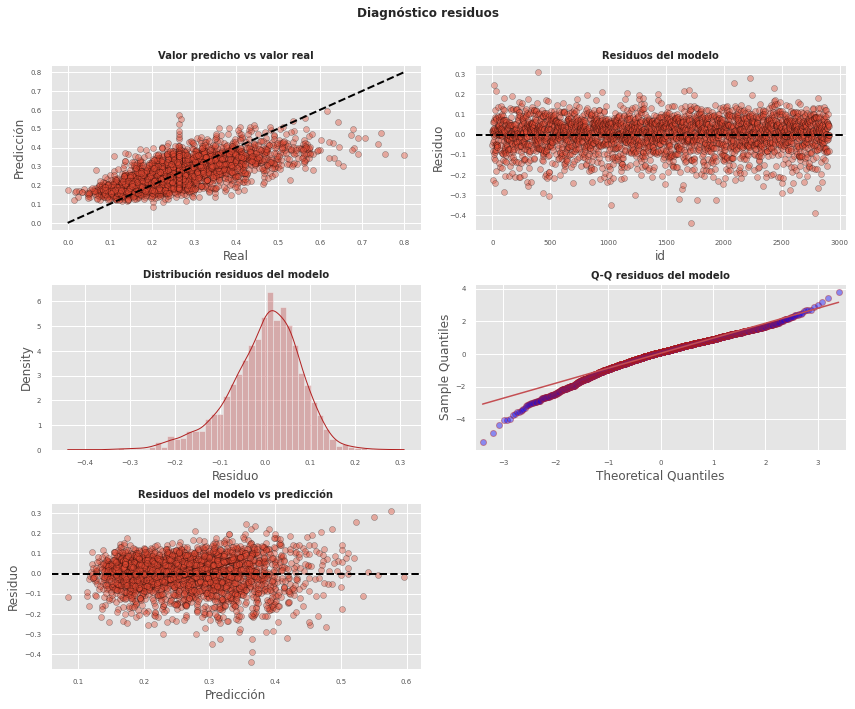

In [73]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

axes[0, 0].scatter(Y2_train, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([Y2_train.min(), Y2_train.max()], [Y2_train.min(), Y2_train.max()],
                'k--', color = 'black', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(Y2_train))), residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = residuos_train,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    residuos_train,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

axes[2, 0].scatter(prediccion_train, residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
axes[2, 0].set_xlabel('Predicción')
axes[2, 0].set_ylabel('Residuo')
axes[2, 0].tick_params(labelsize = 7)

fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

In [74]:
X2_test = X2_test[X_train_new.columns[1:len(X_train_new)]] 
X2_test = sm.add_constant(X2_test)

In [76]:
predicciones = lm.predict(exog = X2_test)

mse = mean_squared_error (y_true  = Y2_test, y_pred  = predicciones, squared = True)
rmse = mean_squared_error (y_true  = Y2_test, y_pred = predicciones, squared = False)
MAE = mean_absolute_error (y_true  = Y2_test, y_pred = predicciones)
MedAE = median_absolute_error (y_true  = Y2_test, y_pred  = predicciones)
r2 = r2_score (y_true  = Y2_test, y_pred  = predicciones)

print(f"El error MSE   de test es: {mse}")
print(f"El error RMSE  de test es: {rmse}")
print(f"El error MAE   de test es: {MAE}")
print(f"El error MedAE de test es: {MedAE}")
print(f"El error R2    de test es: {r2}")

El error MSE   de test es: 0.006795702704984235
El error RMSE  de test es: 0.08243605221615258
El error MAE   de test es: 0.06241925540923981
El error MedAE de test es: 0.04892248820460113
El error R2    de test es: 0.48141338180262505
